In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = 1000
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [161]:
def ue_moviment(velocity, steps):
    '''Moves a User Equipment (UE) in a given direction at a given speed.
    
    Parameters:
    velocity (float): The speed at which the UE is moving in meters per second.
    steps (int): The number of steps to move the UE.
    
    Returns:
    np.array: The new coordinates of the UE.'''
    
    theta = np.linspace(0, 2*np.pi, 720)
    x_coord = []
    y_coord = []    
    
    x, y = 0, 0

    for iterations in range(steps):
        angle = np.random.choice(theta)
        x += velocity * np.cos(angle)
        y += velocity * np.sin(angle)

        if x > 1000:
            x = 1000
        elif x < 0:
            x = 0

        if y > 1000:
            y = 1000
        elif y < 0:
            y = 0
        x_coord.append(x)
        y_coord.append(y)


    return x_coord, y_coord

In [162]:
#Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

#Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

In [163]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  return dAPUE

In [164]:
#Função que define o shadowing e muda ele a cada 10 passos
def find_shadowing(passos):
    '''Generate shadowing values that change every 10 steps based on a log-normal distribution.

    Parameters:
    num_steps (int): The number of steps for which shadowing values are needed.

    Returns:
    list: A list of shading values for each step, changing every 10 steps.'''
    shadowing = []

    valor_atual = np.random.lognormal(0, 4)  # Inicializa o shadowing com sigma = 2 [LINEAR]
    for i in range(passos):
        if (i) % 100 == 0 and i != 0:  # Atualiza o shadowing a cada 10 passos, exceto no passo 0
            valor_atual = np.random.lognormal(0, 2)
        shadowing.append(valor_atual)  # Adiciona o valor atual à lista
    return shadowing 

In [165]:
# Função que calcula o path gain
def find_path_gain(dist, shadowing):
    ''' Calculate the path gain for a given distance and shadowing value.

    Parameters:
    distance (float): The distance from the transmitter to the receiver.
    shadowing (float): The shadowing effect value, typically a multiplier derived from a log-normal distribution.

    Returns:
    float: The path gain calculated using the given distance and shadowing effects.'''
    k = 1e-4
    n = 4
    path_gain_result = shadowing * (k / ((dist) ** n)) #Obtem o path_gain local de cada AP

    return path_gain_result # [LINEAR]

In [166]:
# Função que calcula a potência recebida
def find_pot_rec(pot_trans, dist, d_0, shadowing):
    ''''Calculate the received power from a transmitter to a receiver based on the distance, 
    transmission power, and shadowing effect.

    Parameters:
    pot_trans (float): The transmission power.
    dist (float): The distance from the transmitter to the receiver.
    d_0 (float): The threshold distance below which the power calculation does not occur.
    shadowing (float): The shadowing effect, modifying the power based on environmental factors.

    Returns:
    float: The received power if distance is above the threshold; otherwise, returns zero.'''
    k = 1e-4
    n = 4
    beta = (-30.5 - 36.7*np.log10(dist/1)) # dB
    linear_beta = 10 ** (beta / 10) # Linear

    if dist >= d_0:
        pot_rec_result = shadowing * (pot_trans * linear_beta) #Obtem a potência recebida de cada AP
    else:
        pot_rec_result = 0

    return pot_rec_result # [LINEAR]

In [167]:
def calculate_snr(B_t, p_t, d_0, K_0, M, N, passos, shadowing, cluster, x_coord, y_coord):
    '''Calculate the Signal-to-Noise Ratio (SNR) as a user equipment moves through a given path.

    Parameters:
    B_t (float): Total bandwidth.
    p_t (float): Transmit power.
    d_0 (float): Minimum distance for power calculation.
    K_0 (float): Noise figure (or power of the noise).
    M (int): Number of Access Points (APs).
    N (int): Number of channels.
    passos (int): Number of steps in the simulation.
    shadowing (list): List of shadowing values affecting signal quality.
    cluster (int): Number of APs considered in the calculation of SNR.
    x_coord (list): List of x-coordinates for the UE.
    y_coord (list): List of y-coordinates for the UE.

    Returns:
    list: A list of SNR values for each step in the simulation.'''

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    snr = np.zeros(cluster)
    snr_final = []
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        max_index = np.argsort(path_gain)[-cluster:][::-1]
        for clust in range(len(max_index) ):
            indice = max_index[clust]
            power_rec[clust] = find_pot_rec(p_t, distance[indice], d_0, shadowing[passo])
            snr[clust] = power_rec[clust]/power_noise
        snr_sum = np.sum(snr)
        snr_final.append(snr_sum)
    return snr_final

In [201]:
def calculate_snr_acom(B_t, p_t, d_0, K_0, M, N, passos, shadowing, x_coord, y_coord):
    '''Calculate the Signal-to-Noise Ratio (SNR) as a user equipment moves through a given path.

    Parameters:
    B_t (float): Total bandwidth.
    p_t (float): Transmit power.
    d_0 (float): Minimum distance for power calculation.
    K_0 (float): Noise figure (or power of the noise).
    M (int): Number of Access Points (APs).
    N (int): Number of channels.
    passos (int): Number of steps in the simulation.
    shadowing (list): List of shadowing values affecting signal quality.
    x_coord (list): List of x-coordinates for the UE.
    y_coord (list): List of y-coordinates for the UE.

    Returns:
    list: A list of SNR values for each step in the simulation.'''

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    snr = np.zeros(M)
    snr_final = []
    ci = 0
    ci_values = []  # Lista para armazenar os valores de ci
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
            while ci < len(path_gain) - 1 and path_gain[ci] <= 1e-17:
                ci += 1
        ci_values.append(ci)  # Adicionando o valor de ci à lista
        max_index = np.argsort(path_gain)[-ci:][::-1]
        for clust in range(len(max_index) ):
            indice = max_index[clust]
            power_rec[clust] = find_pot_rec(p_t, distance[indice], d_0, shadowing[passo])
            snr[clust] = power_rec[clust]/power_noise
        snr_sum = np.sum(snr)
        snr_final.append(snr_sum)

    return snr_final, ci_values

In [221]:
def max_cluster_number (M, passos, shadowing, x_coord, y_coord, velocity):
    '''Determines the maximum number of APs in a cluster based on path gain.
    
    Parameters:
    M (int): Number of Access Points (APs).
    passos (int): Number of simulation steps (distance steps).
    shadowing (list): List of shadowing values for each step.
    velocity (float): Speed at which the user equipment moves.
    
    Returns:
    int: The step index where path gains stop increasing consistently.'''
    x_coord, y_coord = ue_moviment(velocity, passos)    

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    ci = 0
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        while ci < len(path_gain) and path_gain[ci] <= path_gain[ci+1]:
            ci += 1

    return ci

In [ ]:
def find_masterap(M, passos, shadowing, cluster, x_coord, y_coord): 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    distance = np.zeros(M)
    path_gain = np.zeros(M)

    
    masterap = -1  
    changes = -1 

    # Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        max_index = np.argsort(path_gain)[-cluster:][::-1]
        if masterap not in max_index:  # Se o Master AP não está mais no cluster
            masterap = max_index[0]  # Atualiza o Master AP
            changes += 1  # Incrementa o contador de mudanças

    return changes

In [ ]:
def calculate_capacity(B_t, p_t, d_0, K, M, N, passos, shadowing, cluster):
    ''' Calculates the channel capacity over a number of steps in a simulation.

    Parameters:
    B_t (float): Total bandwidth available.
    p_t (float): Transmit power of the source.
    d_0 (float): Reference distance for the path loss calculations.
    K (float): Noise figure or noise power.
    M (int): Number of Access Points.
    N (int): Number of channels.
    passos (int): Number of steps or points in the simulation.
    shadowing (list): Shadowing effects at each step.
    cluster (int): Number of APs considered in the cluster for SNR calculations.

    Returns:
    np.array: An array of capacity values for each step in the simulation.'''
    
    snr= calculate_snr(B_t, p_t, d_0, K, M, N, passos, shadowing, cluster)
    B_c = B_t/N
    capacity = np.zeros(passos)
    for i in range(passos):
        capacity[i] = B_c * np.log2(1 + snr[i])
        
    return capacity


In [207]:
B_t, p_t, d_0, K_0 = 100e6, 1e3, 1, 1e-17 # Em MHz, mW, metros, mW/Hz respectivamente
ap, ue, channel = 100, 1, 1
passos = 10000 # Definido já que a UE irá se mover metro por metro
velocity = 15 # Velocidade de 10 m/s
shadow = find_shadowing(passos) # Definindo o shadowing
x_coord, y_coord = ue_moviment(velocity, passos) # Movimentando a UE
passos_array = np.arange(passos)

In [212]:
cluster1, cluster2, cluster3 = 1, 9, 100 # Informa com quantas APs a UE irá se comunicar  (Handover)
snr1 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster1, x_coord, y_coord)
snr2 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster2, x_coord, y_coord)
snr3 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster3, x_coord, y_coord)

snr1 = lin2db(snr1)
snr2 = lin2db(snr2)
snr3 = lin2db(snr3)


cdf_snr1 = np.sort(snr1)
cdf_snr2 = np.sort(snr2)
cdf_snr3 = np.sort(snr3)


C:\Users\joaov\AppData\Local\Temp\ipykernel_29780\2208342905.py:3: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


In [202]:
snr4, cc = calculate_snr_acom(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, x_coord, y_coord)
snr4 = lin2db(snr4)
cdf_snr4 = np.sort(snr4)


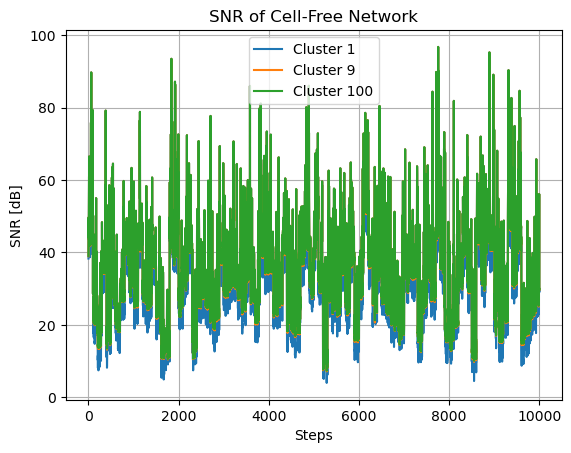

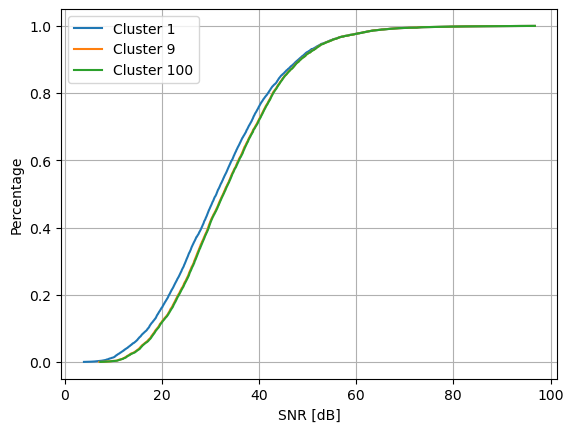

9.0753


In [213]:
# Plotando a SNR pela distância percorrida
plt.plot(passos_array, snr1, label=f'Cluster {cluster1}')
plt.plot(passos_array, snr2, label=f'Cluster {cluster2}')
plt.plot(passos_array, snr3, label=f'Cluster {cluster3}')
#plt.plot(passos_array, snr4, label='Cluster Varíavel')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('SNR [dB]')
plt.title('SNR of Cell-Free Network')
plt.grid()
#plt.savefig('snr.png')
plt.show()

# Plotando a CDF da SNR
plt.plot(cdf_snr1, np.arange(0, len(snr1)) / len(snr1), label=f'Cluster {cluster1}')
plt.plot(cdf_snr2, np.arange(0, len(snr2)) / len(snr2), label=f'Cluster {cluster2}')
plt.plot(cdf_snr3, np.arange(0, len(snr3)) / len(snr3), label=f'Cluster {cluster3}')
#plt.plot(cdf_snr4, np.arange(0, len(snr4)) / len(snr4), label='Cluster Varíavel')
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel('Percentage')
#plt.title('SNR CDF of Cell-Free Network')
plt.grid()
plt.savefig('cdf_snr.pdf')
plt.show()


cc=np.mean(cc)
print(cc)


In [210]:
clustermaster1, clustermaster2, clustermaster3 = 1, 9, 100
master1 = find_masterap(ap, passos, shadow, clustermaster1, x_coord, y_coord)
master2 = find_masterap(ap, passos, shadow, clustermaster2, x_coord, y_coord)
master3 = find_masterap(ap, passos, shadow, clustermaster3, x_coord, y_coord)

# Transformando em mudanças por segundo
master1 = master1 / passos
master2 = master2 / passos
master3 = master3 / passos

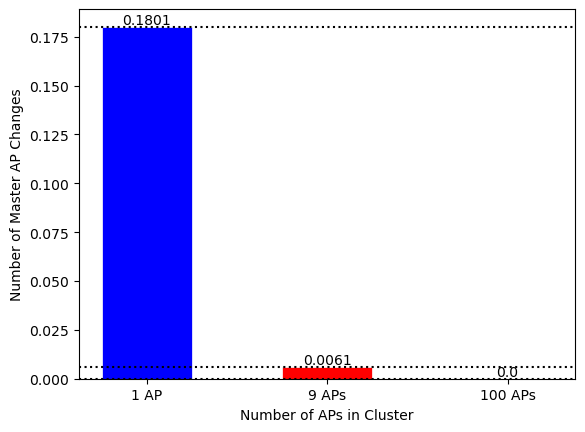

0.1801 0.0061 0.0


In [211]:
# Plotando o gráfico de barras
fig, ax = plt.subplots()

# Posições das barras
xs = np.arange(3)

# Plotando as barras
ax.bar(0, master1, width=0.5, color='b', edgecolor="white", linewidth=0.5)
ax.bar(1, master2, width=0.5, color='r', edgecolor="white", linewidth=0.5)
ax.bar(2, master3, width=0.5, color='y', edgecolor="white", linewidth=0.5)

# Adicionando linhas pontilhadas e rótulos
for x, y in zip(xs, [master1, master2, master3]):
    ax.axhline(y, linestyle='dotted', color='black')
    ax.text(x, y, str(y), ha='center', va='bottom')

x_labels = [f"{clustermaster1} AP", f"{clustermaster2} APs", f"{clustermaster3} APs"]

# Configurando os rótulos dos eixos e título
ax.set_xlabel("Number of APs in Cluster")
ax.set_ylabel("Number of Master AP Changes")
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.savefig('masterap.pdf')
# Mostrando o gráfico
plt.show()

print(master1, master2, master3)

In [ ]:
'''import matplotlib.pyplot as plt

# Suponha que distribuir_APs() retorne uma lista de coordenadas das APs
aps = distribuir_APs(100)

# Coordenadas iniciais da UE
ue = (15, 500)

# Cria um novo gráfico
fig, ax = plt.subplots()

# Plota as APs como triângulos azuis
ax.scatter(*zip(*aps), color='blue', marker='^', label='AP')

# Plota a posição inicial da UE como uma bola vermelha
ax.scatter(*ue, color='red', label='UE')

# Adiciona a legenda
ax.legend()

# Define os limites do gráfico
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
#plt.title('Position of APs and UE')
plt.xlabel('x-axis [m]')
plt.ylabel('y-axis [m]')
plt.grid()
plt.savefig('position.pdf')
# Mostra o gráfico
plt.show()'''

In [223]:
a = max_cluster_number(100, passos, shadow, x_coord, y_coord, velocity)
print(a)

17


In [ ]:
'''def plot_pathgain(B_t, p_t, d_0, K_0, M, N, passos, shadowing):
    #UE irá se mover metro por metro e irá iniciar do ponto (0, 500) e irá até (1000, 500)
    x_coord = np.zeros(passos)
    y_coord = np.zeros(passos)
    for passo in range (passos):
        x_coord[passo] = (passo+1)
        y_coord[passo] = 500 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
       
    return path_gain'''

In [ ]:
'''import matplotlib.pyplot as plt
import numpy as np
import imageio

# Suponha que distribuir_APs() retorne uma lista de coordenadas das APs
aps = distribuir_APs(100)

# Cria uma lista para armazenar os quadros
frames = []

# Calcula as coordenadas do usuário uma vez antes do loop
x_coord = np.arange(1, passos + 1)
y_coord = np.full(passos, 500)

for passo in range(passos):
    # Cria um novo gráfico
    fig, ax = plt.subplots()

    # Plota as APs como triângulos azuis apontando para cima
    ax.scatter(*zip(*aps), color='blue', marker='^', label='triângulo azul - AP')

    # Plota a posição atual do usuário como uma bola vermelha
    ax.scatter(x_coord[passo], y_coord[passo], color='red', label='bola vermelha - UE em movimento')

    # Adiciona a legenda
    ax.legend()

    # Salva o gráfico como uma imagem e adiciona à lista de quadros
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Cria um GIF a partir dos quadros com 4 vezes a velocidade original
imageio.mimsave('movimento.gif', frames, fps=150)'''